In [2]:
%pip install h5py numpy matplotlib pandas

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('default')   

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 27.8 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
h5path = '../data_set/N-CMAPSS_DS02-006.h5'

hdf = h5py.File(h5path, 'r')

print("Top level datasets in the HDF5 file:")
for key in hdf.keys():
    print(f"{key:10s}   shape: {hdf[key].shape}   dtype: {hdf[key].dtype}")

Top level datasets in the HDF5 file:
A_dev        shape: (5263447, 4)   dtype: float64
A_test       shape: (1253743, 4)   dtype: float64
A_var        shape: (4,)   dtype: |S5
T_dev        shape: (5263447, 10)   dtype: float64
T_test       shape: (1253743, 10)   dtype: float64
T_var        shape: (10,)   dtype: |S12
W_dev        shape: (5263447, 4)   dtype: float64
W_test       shape: (1253743, 4)   dtype: float64
W_var        shape: (4,)   dtype: |S4
X_s_dev      shape: (5263447, 14)   dtype: float64
X_s_test     shape: (1253743, 14)   dtype: float64
X_s_var      shape: (14,)   dtype: |S4
X_v_dev      shape: (5263447, 14)   dtype: float64
X_v_test     shape: (1253743, 14)   dtype: float64
X_v_var      shape: (14,)   dtype: |S5
Y_dev        shape: (5263447, 1)   dtype: int64
Y_test       shape: (1253743, 1)   dtype: int64


In [20]:
def decode(byte_array):
    return [x.decode('utf-8') for x in byte_array]

A_var = decode(hdf["A_var"])
T_var = decode(hdf["T_var"])
W_var = decode(hdf["W_var"])
Xs_var = decode(hdf["X_s_var"])
Xv_var = decode(hdf["X_v_var"])

print("A columns:", A_var)
print("T columns:", T_var)
print("W columns:", W_var)
print("Xs columns:", Xs_var)
print("Xv columns:", Xv_var)

A columns: ['unit', 'cycle', 'Fc', 'hs']
T columns: ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
W columns: ['alt', 'Mach', 'TRA', 'T2']
Xs columns: ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
Xv columns: ['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']


In [22]:
A_dev = hdf["A_dev"][:]
T_dev = hdf["T_dev"][:]
W_dev = hdf["W_dev"][:]
Xs_dev = hdf["X_s_dev"][:]
Xv_dev = hdf["X_v_dev"][:]
Y_dev = hdf["Y_dev"][:]


In [24]:
df_A = pd.DataFrame(A_dev, columns=A_var)
df_W = pd.DataFrame(W_dev, columns=W_var)
df_Xs = pd.DataFrame(Xs_dev, columns=Xs_var)
df_T = pd.DataFrame(T_dev, columns=T_var)

df_dev = pd.concat([df_A, df_W, df_Xs, df_T], axis=1)
df_dev['RUL'] = Y_dev[:, 0]

df_dev.head()

,unit,cycle,Fc,hs,alt,Mach,TRA,T2,T24,T30,...,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,RUL
0,2.0,1.0,3.0,1.0,10005.0,0.448497,76.903748,502.420918,600.148034,1438.498187,...,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0,74
1,2.0,1.0,3.0,1.0,10013.0,0.447741,76.903748,502.326114,600.055894,1438.350208,...,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0,74
2,2.0,1.0,3.0,1.0,10017.0,0.448938,77.079529,502.416067,600.210756,1439.109101,...,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0,74
3,2.0,1.0,3.0,1.0,10024.0,0.449883,77.079529,502.469893,600.369717,1439.240230,...,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0,74
4,2.0,1.0,3.0,1.0,10031.0,0.449379,77.079529,502.401271,600.298227,1439.064004,...,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0,74


In [25]:
print("Number of rows in dev set:", len(df_dev))
print("Number of engines in dev set:", df_dev['unit'].nunique())
print("\nCycles per engine (min/max):")
print(df_dev.groupby('unit')['cycle'].agg(['min', 'max']).describe())

df_dev.describe().T.head(15)

Number of rows in dev set: 5263447
Number of engines in dev set: 6

Cycles per engine (min/max):
       min        max
count  6.0   6.000000
mean   1.0  74.333333
std    0.0   9.831921
min    1.0  63.000000
25%    1.0  67.250000
50%    1.0  73.000000
75%    1.0  80.250000
max    1.0  89.000000


,count,mean,std,min,25%,50%,75%,max
unit,5263447.0,11.407231,6.630305,2.000000,5.000000,10.000000,18.000000,20.000000
cycle,5263447.0,37.953343,22.372678,1.000000,19.000000,37.000000,56.000000,89.000000
Fc,5263447.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
hs,5263447.0,0.217866,0.412796,0.000000,0.000000,0.000000,0.000000,1.000000
alt,5263447.0,21901.029770,6288.497692,10001.000000,16451.000000,22996.000000,27912.000000,35033.000000
Mach,5263447.0,0.623772,0.079198,0.258048,0.566055,0.639009,0.690984,0.749259
TRA,5263447.0,68.547416,14.549315,23.554520,59.413639,74.618607,79.628342,87.626328
T2,5263447.0,475.008616,16.586381,421.377893,460.882090,473.038812,489.370787,510.814621
T24,5263447.0,559.058296,17.938425,484.197171,546.728234,556.327207,571.105630,616.796557
T30,5263447.0,1319.334998,55.494439,1068.822659,1288.784194,1318.392717,1353.122140,1487.274864


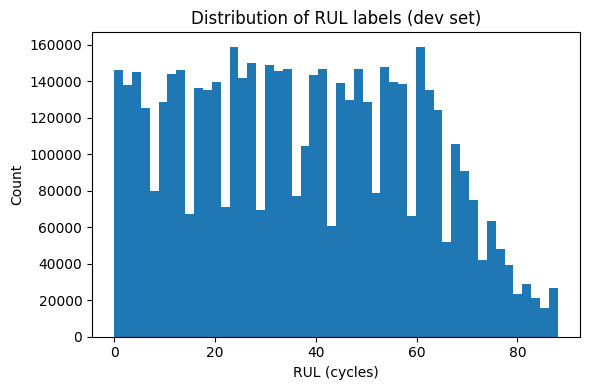

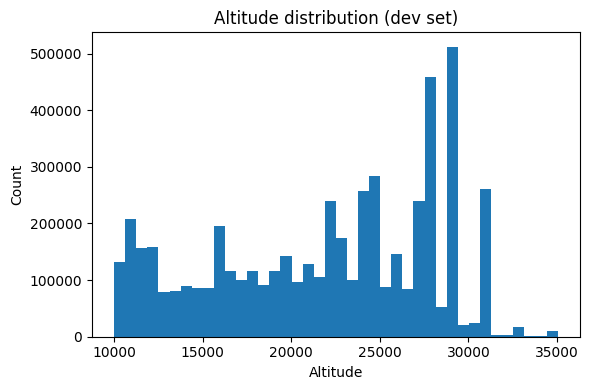

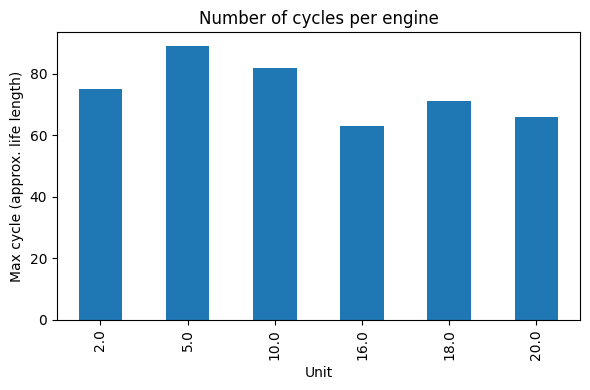

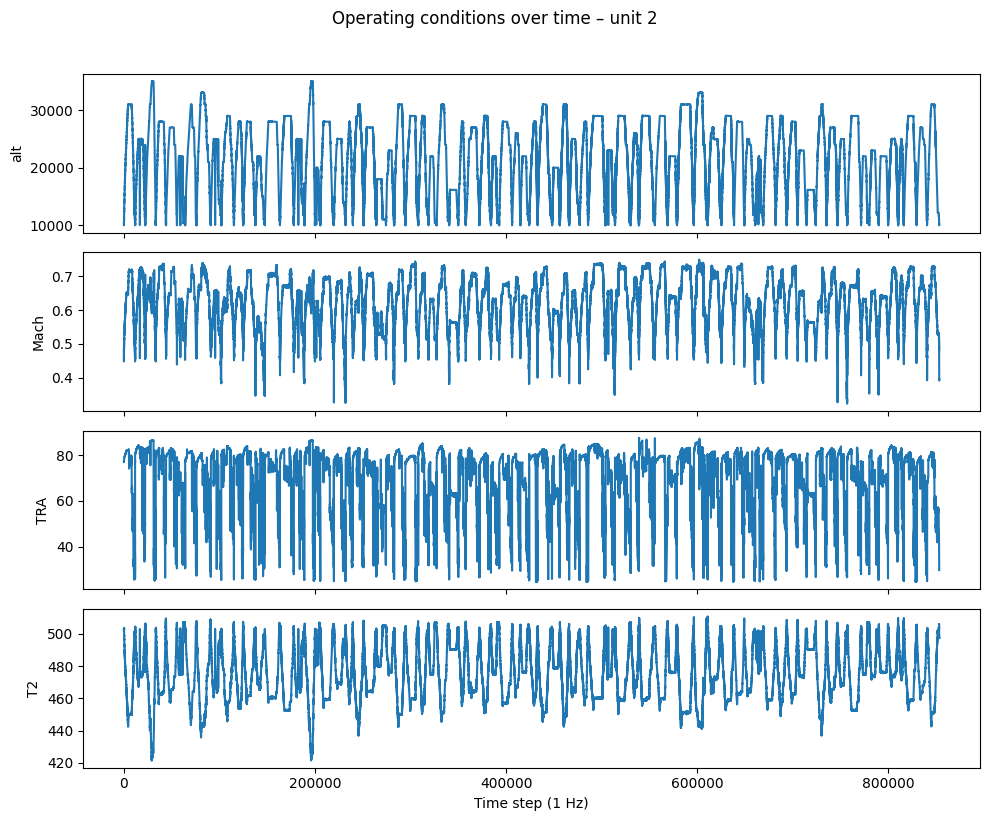

C:\Users\vaibh\AppData\Local\Temp\ipykernel_25604\3058758614.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\vaibh\miniconda3\envs\cs178\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


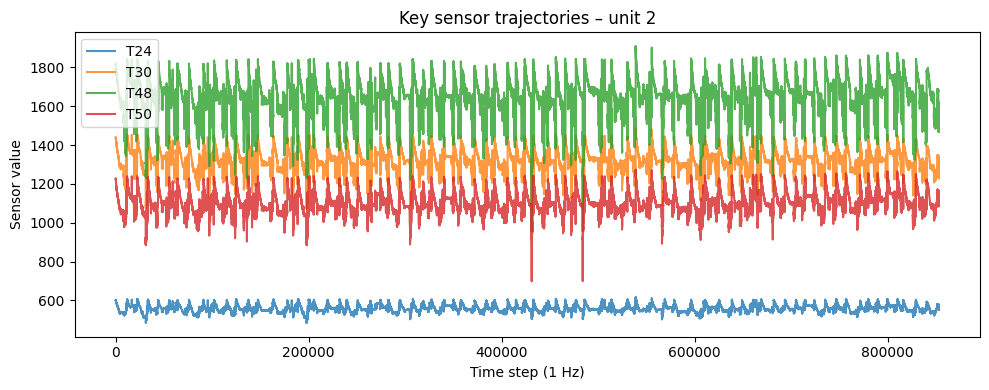

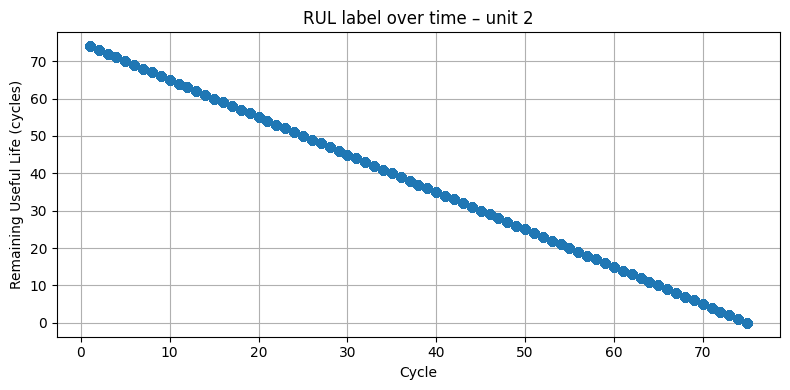

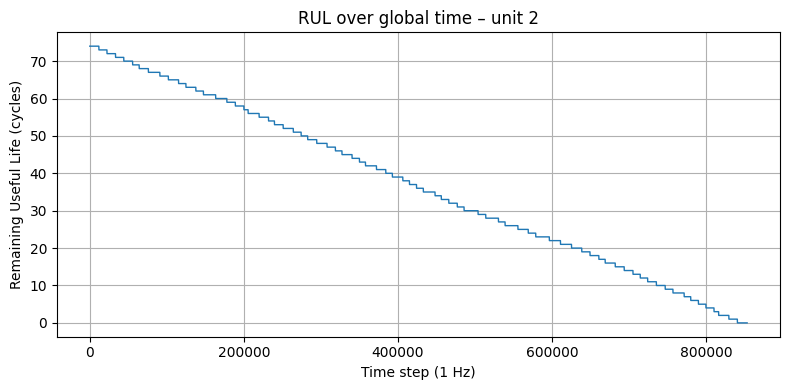

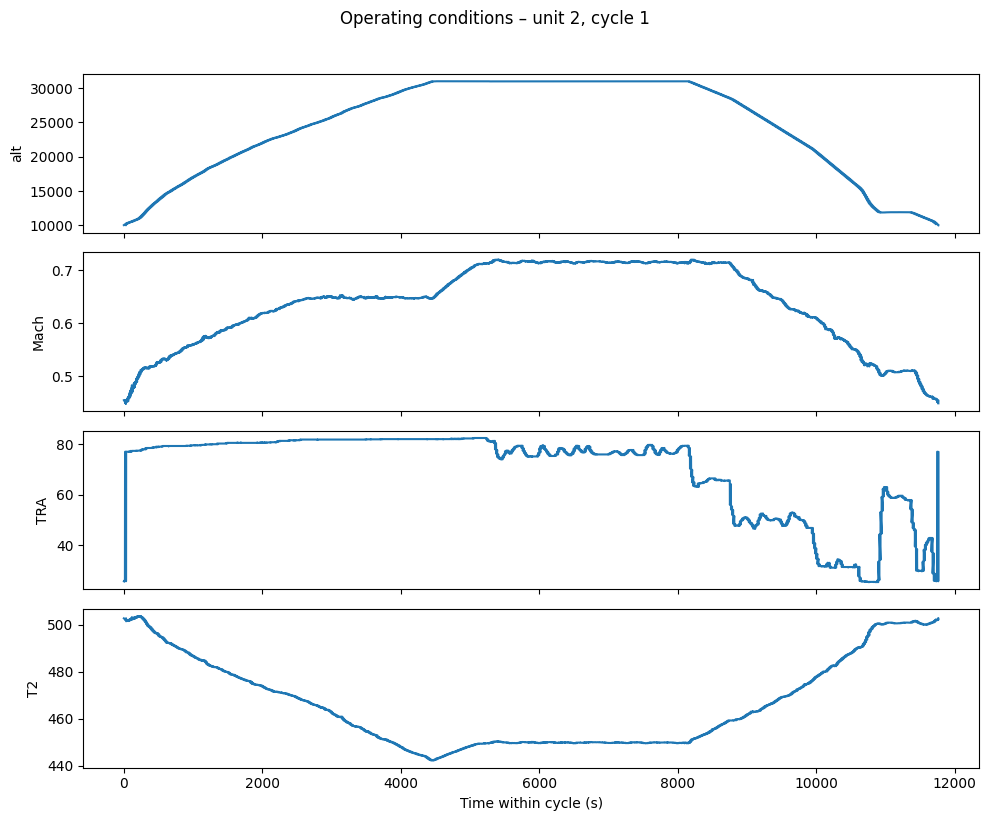

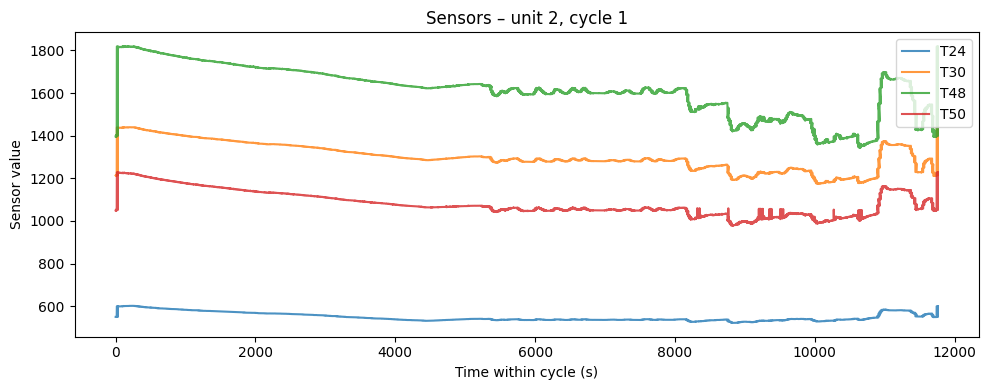

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ========= CONFIG =========
unit_id  = 2   # engine to visualize
cycle_id = 1   # one flight from that engine
# choose some sensors to look at (adjust based on your X_s columns)
sensor_cols = ["T24", "T30", "T48", "T50"]  
op_cols     = ["alt", "Mach", "TRA", "T2"]
# ==========================

# --- Create some helper columns ---
df_unit = df_dev[df_dev["unit"] == unit_id].copy().sort_values(["cycle"])
df_unit["time_idx"] = np.arange(len(df_unit))

df_uc = df_dev[(df_dev["unit"] == unit_id) & (df_dev["cycle"] == cycle_id)].copy()
df_uc = df_uc.sort_values(df_uc.columns[0])   # just to have a stable order
df_uc["t_in_cycle"] = np.arange(len(df_uc))

# ========== GLOBAL PLOTS (ALL ENGINES) ==========

# 1) RUL distribution
plt.figure(figsize=(6, 4))
plt.hist(df_dev["RUL"], bins=50)
plt.xlabel("RUL (cycles)")
plt.ylabel("Count")
plt.title("Distribution of RUL labels (dev set)")
plt.tight_layout()
plt.show()

# 2) Altitude distribution
plt.figure(figsize=(6, 4))
plt.hist(df_dev["alt"], bins=40)
plt.xlabel("Altitude")
plt.ylabel("Count")
plt.title("Altitude distribution (dev set)")
plt.tight_layout()
plt.show()

# 3) Cycles per engine
cycles_per_unit = df_dev.groupby("unit")["cycle"].max()
plt.figure(figsize=(6, 4))
cycles_per_unit.plot(kind="bar")
plt.xlabel("Unit")
plt.ylabel("Max cycle (approx. life length)")
plt.title("Number of cycles per engine")
plt.tight_layout()
plt.show()

# ========== PER-ENGINE PLOTS (UNIT = unit_id) ==========

# 4) Operating conditions vs global time index
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

for ax, col in zip(axes, ["alt", "Mach", "TRA", "T2"]):
    ax.plot(df_unit["time_idx"], df_unit[col])
    ax.set_ylabel(col)

axes[-1].set_xlabel("Time step (1 Hz)")
fig.suptitle(f"Operating conditions over time – unit {unit_id}", y=1.02)
plt.tight_layout()
plt.show()

# 5) Sensors vs global time index
plt.figure(figsize=(10, 4))
for col in sensor_cols:
    plt.plot(df_unit["time_idx"], df_unit[col], label=col, alpha=0.8)
plt.xlabel("Time step (1 Hz)")
plt.ylabel("Sensor value")
plt.title(f"Key sensor trajectories – unit {unit_id}")
plt.legend()
plt.tight_layout()
plt.show()

# 6) RUL vs cycle for this engine
plt.figure(figsize=(8, 4))
plt.plot(df_unit["cycle"], df_unit["RUL"], marker="o", linewidth=1)
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title(f"RUL label over time – unit {unit_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7) RUL vs global time index (same info, different x-axis)
plt.figure(figsize=(8, 4))
plt.plot(df_unit["time_idx"], df_unit["RUL"], linewidth=1)
plt.xlabel("Time step (1 Hz)")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title(f"RUL over global time – unit {unit_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== SINGLE-FLIGHT (CYCLE) PLOTS ==========

fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

for ax, col in zip(axes, ["alt", "Mach", "TRA", "T2"]):
    ax.plot(df_uc["t_in_cycle"], df_uc[col])
    ax.set_ylabel(col)

axes[-1].set_xlabel("Time within cycle (s)")
fig.suptitle(f"Operating conditions – unit {unit_id}, cycle {cycle_id}", y=1.02)
plt.tight_layout()
plt.show()




# 9) Sensors within a single cycle
plt.figure(figsize=(10, 4))
for col in sensor_cols:
    plt.plot(df_uc["t_in_cycle"], df_uc[col], label=col, alpha=0.8)
plt.xlabel("Time within cycle (s)")
plt.ylabel("Sensor value")
plt.title(f"Sensors – unit {unit_id}, cycle {cycle_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
cols = [
    "alt", "Mach", "TRA", "T2",
    "Wf", "Nf", "Nc",
    "T24", "T30", "T48", "T50",
    "P15", "P2", "P21", "Ps30", "P40", "P50"
]

candidate_cols = []
for col in cols:
    if col in df_dev.columns:
        candidate_cols.append(col)  

print("Candidate columns for modeling:", candidate_cols)

corr_w_rul = df_dev[candidate_cols + ["RUL"]].corr()["RUL"].drop("RUL")
corr_w_rul = corr_w_rul.reindex(corr_w_rul.abs().sort_values(ascending=False).index)

corr_w_rul

Candidate columns for modeling: ['alt', 'Mach', 'TRA', 'T2', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'Ps30', 'P40', 'P50']


T50    -0.126475
T48    -0.074675
Nc      0.024205
Wf     -0.020594
Mach    0.015666
T24    -0.011008
alt     0.010162
T30     0.010153
P50    -0.008643
TRA     0.008057
P2     -0.007272
Nf      0.007115
T2     -0.006856
P21    -0.006542
P15    -0.006542
P40     0.002407
Ps30    0.001256
Name: RUL, dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Xall = df_dev[candidate_cols]
yall = df_dev["RUL"]

fraction = 0.05
if fraction < 1.0:
    Xsample = Xall.sample(frac=fraction, random_state=42)
    ysample = yall.loc[Xsample.index]
else:
    Xsample = Xall
    ysample = yall

model = RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)
model.fit(Xsample, ysample)
modelimportances = pd.Series(model.feature_importances_, index=candidate_cols)
modelimportances = modelimportances.sort_values(ascending=False)

print("Random forest importances")
display(modelimportances)

Random forest importances


T50     0.352119
Nc      0.269123
Ps30    0.099277
Wf      0.091006
Mach    0.072241
P40     0.055901
T48     0.032488
Nf      0.010109
TRA     0.007085
T24     0.004126
T2      0.001838
P50     0.001716
P2      0.001188
P21     0.000840
alt     0.000438
P15     0.000355
T30     0.000148
dtype: float64

In [38]:
k = 10
topcorr = corr_w_rul.abs().head(k).index.tolist()
print("Top by correlation:", topcorr)

topimp = modelimportances.head(k).index.tolist()
print("Top by importance:", topimp)

selected = sorted(set(topcorr) | set(topimp))
print("Selected features for modeling:", selected)

feature_cols = selected

Top by correlation: ['T50', 'T48', 'Nc', 'Wf', 'Mach', 'T24', 'alt', 'T30', 'P50', 'TRA']
Top by importance: ['T50', 'Nc', 'Ps30', 'Wf', 'Mach', 'P40', 'T48', 'Nf', 'TRA', 'T24']
Selected features for modeling: ['Mach', 'Nc', 'Nf', 'P40', 'P50', 'Ps30', 'T24', 'T30', 'T48', 'T50', 'TRA', 'Wf', 'alt']
